##Nuclei detection with Mask RCNN

In [218]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

##Configuration

In [271]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

## Dataset

Create a nuclei dataset



In [44]:
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [232]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        mask = np.zeros((height, width, 1), dtype=np.bool)
        for mask_file in next(os.walk(self.image_info[i]['maskpath']))[2]:            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:,:,0] = np.maximum(mask[:,:,0], mask_)   
        class_ids = np.array([1])
        return mask, class_ids
        

In [277]:
#load the first 10 images
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_ids[0:450])
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, train_ids[450:])
dataset_val.prepare()

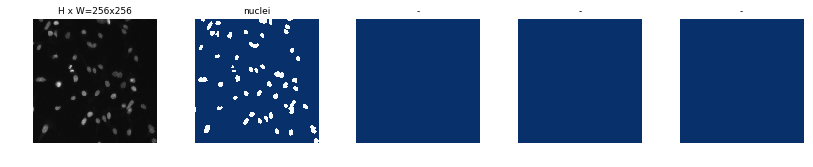

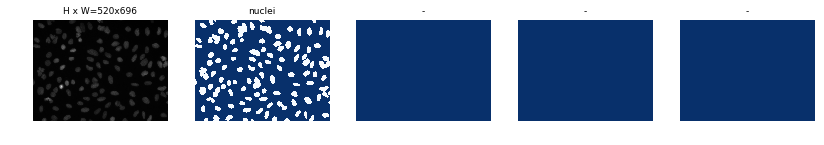

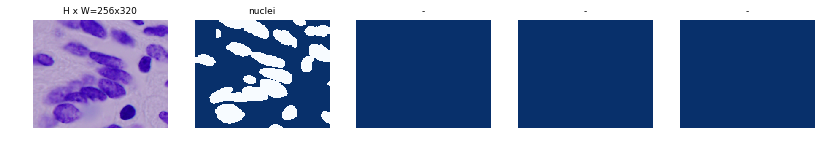

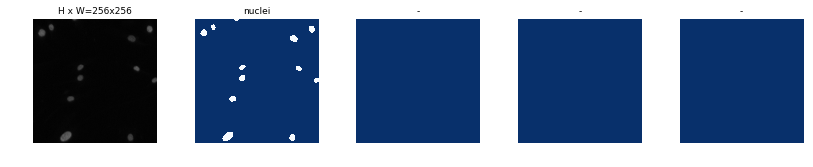

In [278]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


##Create model

In [279]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [280]:
# Which weights to start with? Used coco weights? 
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

##Training
Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [281]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180312T2315/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Epoch 1/1


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  1/100 [..............................] - ETA: 40:02 - loss: 6.2687 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.1251 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 2.0898 - mrcnn_mask_loss: 2.7452

  2/100 [..............................] - ETA: 31:01 - loss: 5.9149 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 1.2973 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 1.8607 - mrcnn_mask_loss: 2.5088

  3/100 [..............................] - ETA: 28:23 - loss: 6.0781 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 1.3462 - mrcnn_class_loss: 0.2257 - mrcnn_bbox_loss: 1.8813 - mrcnn_mask_loss: 2.5909

  4/100 [>.............................] - ETA: 26:43 - loss: 5.7580 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 1.4255 - mrcnn_class_loss: 0.1857 - mrcnn_bbox_loss: 1.6724 - mrcnn_mask_loss: 2.4411

  5/100 [>.............................] - ETA: 25:23 - loss: 5.3892 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.3990 - mrcnn_class_loss: 0.1616 - mrcnn_bbox_loss: 1.6474 - mrcnn_mask_loss: 2.1430

  6/100 [>.............................] - ETA: 24:28 - loss: 5.2982 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.5807 - mrcnn_class_loss: 0.1425 - mrcnn_bbox_loss: 1.6145 - mrcnn_mask_loss: 1.9208

  7/100 [=>............................] - ETA: 23:54 - loss: 5.0405 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.5631 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 1.5619 - mrcnn_mask_loss: 1.7392

  8/100 [=>............................] - ETA: 23:20 - loss: 4.6721 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.4425 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 1.4715 - mrcnn_mask_loss: 1.5944

  9/100 [=>............................] - ETA: 22:49 - loss: 4.5065 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 1.5177 - mrcnn_class_loss: 0.1101 - mrcnn_bbox_loss: 1.3672 - mrcnn_mask_loss: 1.4691

 10/100 [==>...........................] - ETA: 22:22 - loss: 4.5337 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.7003 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 1.3114 - mrcnn_mask_loss: 1.3740

 11/100 [==>...........................] - ETA: 21:59 - loss: 4.2988 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.6164 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 1.2483 - mrcnn_mask_loss: 1.2933

 12/100 [==>...........................] - ETA: 21:37 - loss: 4.2084 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.6110 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 1.2450 - mrcnn_mask_loss: 1.2178

 13/100 [==>...........................] - ETA: 21:17 - loss: 4.1634 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.6484 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 1.2307 - mrcnn_mask_loss: 1.1542

 14/100 [===>..........................] - ETA: 21:00 - loss: 4.0659 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.6354 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 1.1969 - mrcnn_mask_loss: 1.1085

 15/100 [===>..........................] - ETA: 20:40 - loss: 4.0370 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.6561 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 1.1845 - mrcnn_mask_loss: 1.0753

 16/100 [===>..........................] - ETA: 20:22 - loss: 3.8981 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.6004 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 1.1608 - mrcnn_mask_loss: 1.0191

 17/100 [====>.........................] - ETA: 20:04 - loss: 3.8059 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.6057 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 1.1154 - mrcnn_mask_loss: 0.9701

 18/100 [====>.........................] - ETA: 19:47 - loss: 3.7411 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.5486 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 1.1165 - mrcnn_mask_loss: 0.9644

 19/100 [====>.........................] - ETA: 19:31 - loss: 3.7099 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.5614 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 1.0883 - mrcnn_mask_loss: 0.9501

 20/100 [=====>........................] - ETA: 19:13 - loss: 3.6103 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.5149 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 1.0699 - mrcnn_mask_loss: 0.9170

 21/100 [=====>........................] - ETA: 18:55 - loss: 3.5636 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.5200 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 1.0590 - mrcnn_mask_loss: 0.8794

 22/100 [=====>........................] - ETA: 18:38 - loss: 3.5149 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 1.5293 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 1.0341 - mrcnn_mask_loss: 0.8483

 23/100 [=====>........................] - ETA: 18:21 - loss: 3.4429 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.5056 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 1.0138 - mrcnn_mask_loss: 0.8226

 24/100 [======>.......................] - ETA: 18:05 - loss: 3.3879 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.4884 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 1.0028 - mrcnn_mask_loss: 0.7979

 25/100 [======>.......................] - ETA: 17:48 - loss: 3.4716 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.6146 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.9860 - mrcnn_mask_loss: 0.7717

 26/100 [======>.......................] - ETA: 17:33 - loss: 3.4092 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.5771 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.9865 - mrcnn_mask_loss: 0.7472

 27/100 [=======>......................] - ETA: 17:17 - loss: 3.3284 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.5394 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.9653 - mrcnn_mask_loss: 0.7273

 28/100 [=======>......................] - ETA: 17:02 - loss: 3.2744 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.5101 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.9508 - mrcnn_mask_loss: 0.7182

 29/100 [=======>......................] - ETA: 16:46 - loss: 3.2148 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.4737 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.9366 - mrcnn_mask_loss: 0.7103

 30/100 [========>.....................] - ETA: 16:31 - loss: 3.1603 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.4501 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.9254 - mrcnn_mask_loss: 0.6914

 31/100 [========>.....................] - ETA: 16:17 - loss: 3.1615 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.4719 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.9109 - mrcnn_mask_loss: 0.6863

 32/100 [========>.....................] - ETA: 16:02 - loss: 3.1259 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.4477 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.8907 - mrcnn_mask_loss: 0.6966

 33/100 [========>.....................] - ETA: 15:47 - loss: 3.0898 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.4322 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.8745 - mrcnn_mask_loss: 0.6931

 34/100 [=========>....................] - ETA: 15:32 - loss: 3.0783 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 1.4320 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.8604 - mrcnn_mask_loss: 0.6962

 35/100 [=========>....................] - ETA: 15:18 - loss: 3.0323 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.4017 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.8488 - mrcnn_mask_loss: 0.6930

 36/100 [=========>....................] - ETA: 15:03 - loss: 2.9747 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 1.3648 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.8345 - mrcnn_mask_loss: 0.6876

 37/100 [==========>...................] - ETA: 14:49 - loss: 2.9344 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.3353 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.8186 - mrcnn_mask_loss: 0.6934

 38/100 [==========>...................] - ETA: 14:35 - loss: 2.9124 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.3412 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.8025 - mrcnn_mask_loss: 0.6826

 39/100 [==========>...................] - ETA: 14:20 - loss: 2.8843 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.3359 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.7887 - mrcnn_mask_loss: 0.6744

 40/100 [===========>..................] - ETA: 14:06 - loss: 2.8817 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 1.3426 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.7809 - mrcnn_mask_loss: 0.6740

 41/100 [===========>..................] - ETA: 13:51 - loss: 2.8599 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.3359 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.7692 - mrcnn_mask_loss: 0.6713

 42/100 [===========>..................] - ETA: 13:37 - loss: 2.8361 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.3260 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.7553 - mrcnn_mask_loss: 0.6726

 43/100 [===========>..................] - ETA: 13:22 - loss: 3.0015 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 1.4726 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.7753 - mrcnn_mask_loss: 0.6718

 44/100 [============>.................] - ETA: 13:07 - loss: 2.9526 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 1.4420 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.7629 - mrcnn_mask_loss: 0.6666

 45/100 [============>.................] - ETA: 12:52 - loss: 2.9257 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 1.4284 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.7570 - mrcnn_mask_loss: 0.6604

 46/100 [============>.................] - ETA: 12:38 - loss: 2.9522 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 1.4624 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.7550 - mrcnn_mask_loss: 0.6551

 47/100 [=============>................] - ETA: 12:23 - loss: 2.9393 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 1.4650 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.7444 - mrcnn_mask_loss: 0.6510

 48/100 [=============>................] - ETA: 12:09 - loss: 2.9411 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.4777 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.7388 - mrcnn_mask_loss: 0.6461

 49/100 [=============>................] - ETA: 11:55 - loss: 2.9098 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.4581 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.7332 - mrcnn_mask_loss: 0.6405

 50/100 [==============>...............] - ETA: 11:40 - loss: 2.9153 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.4691 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.7318 - mrcnn_mask_loss: 0.6371

 51/100 [==============>...............] - ETA: 11:26 - loss: 2.9174 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 1.4830 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.7255 - mrcnn_mask_loss: 0.6319

 52/100 [==============>...............] - ETA: 11:14 - loss: 2.9112 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 1.4943 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.7137 - mrcnn_mask_loss: 0.6268

 53/100 [==============>...............] - ETA: 13:29 - loss: 2.8838 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 1.4765 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.7116 - mrcnn_mask_loss: 0.6202

 54/100 [===============>..............] - ETA: 13:12 - loss: 2.8654 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 1.4684 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.7035 - mrcnn_mask_loss: 0.6184

 55/100 [===============>..............] - ETA: 12:51 - loss: 2.8516 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 1.4700 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.6957 - mrcnn_mask_loss: 0.6116

 56/100 [===============>..............] - ETA: 12:32 - loss: 2.8302 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 1.4576 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.6888 - mrcnn_mask_loss: 0.6103

 57/100 [================>.............] - ETA: 34:53 - loss: 2.8184 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 1.4503 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.6833 - mrcnn_mask_loss: 0.6124

 58/100 [================>.............] - ETA: 33:44 - loss: 2.7958 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 1.4417 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.6767 - mrcnn_mask_loss: 0.6060

 59/100 [================>.............] - ETA: 32:37 - loss: 2.7779 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 1.4381 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.6706 - mrcnn_mask_loss: 0.5988

 60/100 [=================>............] - ETA: 54:37 - loss: 2.7639 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 1.4402 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.6620 - mrcnn_mask_loss: 0.5921

 61/100 [=================>............] - ETA: 52:40 - loss: 2.8269 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 1.5139 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.6586 - mrcnn_mask_loss: 0.5852

 62/100 [=================>............] - ETA: 50:44 - loss: 2.8055 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 1.5004 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.6520 - mrcnn_mask_loss: 0.5844

 63/100 [=================>............] - ETA: 1:12:25 - loss: 2.7782 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 1.4842 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.6440 - mrcnn_mask_loss: 0.5820

 64/100 [==================>...........] - ETA: 1:09:34 - loss: 2.7497 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 1.4666 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.6359 - mrcnn_mask_loss: 0.5798

 65/100 [==================>...........] - ETA: 1:35:30 - loss: 2.7162 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 1.4456 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.6293 - mrcnn_mask_loss: 0.5746

 66/100 [==================>...........] - ETA: 1:31:34 - loss: 2.6927 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 1.4354 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.6225 - mrcnn_mask_loss: 0.5690

 67/100 [===================>..........] - ETA: 1:53:55 - loss: 2.6720 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 1.4164 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.6164 - mrcnn_mask_loss: 0.5739

 68/100 [===================>..........] - ETA: 1:49:06 - loss: 2.6494 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 1.4037 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.6099 - mrcnn_mask_loss: 0.5712

 69/100 [===================>..........] - ETA: 2:08:13 - loss: 2.6259 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 1.3875 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.5718

 70/100 [====================>.........] - ETA: 2:02:32 - loss: 2.6036 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 1.3709 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.5963 - mrcnn_mask_loss: 0.5729

 71/100 [====================>.........] - ETA: 2:18:39 - loss: 2.5780 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 1.3548 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.5900 - mrcnn_mask_loss: 0.5702

 72/100 [====================>.........] - ETA: 2:12:11 - loss: 2.5523 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 1.3392 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.5863 - mrcnn_mask_loss: 0.5644

 73/100 [====================>.........] - ETA: 2:16:20 - loss: 2.5273 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 1.3264 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.5795 - mrcnn_mask_loss: 0.5598

 74/100 [=====================>........] - ETA: 2:09:39 - loss: 2.5042 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 1.3107 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.5757 - mrcnn_mask_loss: 0.5566

 75/100 [=====================>........] - ETA: 2:03:08 - loss: 2.4831 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 1.2971 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.5734 - mrcnn_mask_loss: 0.5520

 76/100 [=====================>........] - ETA: 1:56:46 - loss: 2.4678 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 1.2919 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.5683 - mrcnn_mask_loss: 0.5475

 77/100 [======================>.......] - ETA: 2:06:23 - loss: 2.4979 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 1.3235 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.5714 - mrcnn_mask_loss: 0.5429

 78/100 [======================>.......] - ETA: 1:59:28 - loss: 2.4754 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.3088 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.5664 - mrcnn_mask_loss: 0.5404

 79/100 [======================>.......] - ETA: 2:06:51 - loss: 2.4575 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.2940 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.5630 - mrcnn_mask_loss: 0.5414

 80/100 [=======================>......] - ETA: 1:59:24 - loss: 2.4351 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 1.2785 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.5581 - mrcnn_mask_loss: 0.5399

 81/100 [=======================>......] - ETA: 2:04:35 - loss: 2.4140 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 1.2632 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.5542 - mrcnn_mask_loss: 0.5384

 82/100 [=======================>......] - ETA: 1:56:42 - loss: 2.3945 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 1.2500 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.5485 - mrcnn_mask_loss: 0.5383

 83/100 [=======================>......] - ETA: 1:59:52 - loss: 2.3772 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.2354 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.5440 - mrcnn_mask_loss: 0.5404

 84/100 [========================>.....] - ETA: 1:51:34 - loss: 2.3607 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 1.2217 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.5426 - mrcnn_mask_loss: 0.5393

 85/100 [========================>.....] - ETA: 1:43:31 - loss: 2.3450 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 1.2124 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.5353

 86/100 [========================>.....] - ETA: 1:35:33 - loss: 2.3289 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 1.2012 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.5386 - mrcnn_mask_loss: 0.5332

 87/100 [=========================>....] - ETA: 1:27:45 - loss: 2.3227 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.1965 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.5362 - mrcnn_mask_loss: 0.5344

 88/100 [=========================>....] - ETA: 1:20:06 - loss: 2.3125 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 1.1916 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.5334 - mrcnn_mask_loss: 0.5320

 89/100 [=========================>....] - ETA: 1:12:39 - loss: 2.2967 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 1.1805 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.5290 - mrcnn_mask_loss: 0.5321

 90/100 [==========================>...] - ETA: 1:05:20 - loss: 2.2899 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.1771 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.5285 - mrcnn_mask_loss: 0.5290

 91/100 [==========================>...] - ETA: 58:10 - loss: 2.2744 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 1.1657 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.5239 - mrcnn_mask_loss: 0.5300  

 92/100 [==========================>...] - ETA: 51:10 - loss: 2.2722 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 1.1631 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.5273 - mrcnn_mask_loss: 0.5274

 93/100 [==========================>...] - ETA: 47:51 - loss: 2.2564 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 1.1513 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.5229 - mrcnn_mask_loss: 0.5280

 94/100 [===========================>..] - ETA: 40:51 - loss: 2.2441 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 1.1431 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.5200 - mrcnn_mask_loss: 0.5273

 95/100 [===========================>..] - ETA: 33:42 - loss: 2.2287 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.1324 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.5192 - mrcnn_mask_loss: 0.5238

 96/100 [===========================>..] - ETA: 26:41 - loss: 2.2152 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 1.1243 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.5150 - mrcnn_mask_loss: 0.5231

 97/100 [============================>.] - ETA: 19:49 - loss: 2.1990 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 1.1142 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.5118 - mrcnn_mask_loss: 0.5204

 98/100 [============================>.] - ETA: 13:05 - loss: 2.1955 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.1184 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.5073 - mrcnn_mask_loss: 0.5173

 99/100 [============================>.] - ETA: 6:28 - loss: 2.1901 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 1.1167 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.5036 - mrcnn_mask_loss: 0.5176 

100/100 [==============================] - 38507s 385s/step - loss: 2.1790 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 1.1123 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.4994 - mrcnn_mask_loss: 0.5152 - val_loss: 1.4157 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.9676 - val_mrcnn_class_loss: 0.0175 - val_mrcnn_bbox_loss: 0.2178 - val_mrcnn_mask_loss: 0.2117


In [282]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180312T2315/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Epoch 2/2


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  1/100 [..............................] - ETA: 45:52 - loss: 0.7778 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.5209

  2/100 [..............................] - ETA: 35:33 - loss: 0.7987 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1280 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.5611

  3/100 [..............................] - ETA: 31:39 - loss: 0.7659 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1540 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.1663 - mrcnn_mask_loss: 0.4309

  4/100 [>.............................] - ETA: 29:29 - loss: 0.8382 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2135 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.1897 - mrcnn_mask_loss: 0.4144

  5/100 [>.............................] - ETA: 28:01 - loss: 0.7534 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1987 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.3680

  6/100 [>.............................] - ETA: 26:58 - loss: 0.7441 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1766 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.4016

  7/100 [=>............................] - ETA: 26:12 - loss: 0.7977 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1861 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.4326

  8/100 [=>............................] - ETA: 25:35 - loss: 0.7712 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1891 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.4007

  9/100 [=>............................] - ETA: 25:00 - loss: 0.9326 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3536 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1870 - mrcnn_mask_loss: 0.3740

 10/100 [==>...........................] - ETA: 24:31 - loss: 0.9718 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3773 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.3826

 11/100 [==>...........................] - ETA: 24:03 - loss: 0.9547 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3531 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1809 - mrcnn_mask_loss: 0.4028

 12/100 [==>...........................] - ETA: 23:44 - loss: 2.1712 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.6122 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.3692

 13/100 [==>...........................] - ETA: 23:34 - loss: 2.0671 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5029 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.3845

 14/100 [===>..........................] - ETA: 49:28 - loss: 1.9726 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.3997 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.3946

 15/100 [===>..........................] - ETA: 47:28 - loss: 3.0784 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 2.3853 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.4340

 16/100 [===>..........................] - ETA: 45:17 - loss: 2.9325 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 2.2429 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.4410

 17/100 [====>.........................] - ETA: 43:19 - loss: 2.8072 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 2.1298 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.4276

 18/100 [====>.........................] - ETA: 41:36 - loss: 2.6896 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 2.0132 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.2138 - mrcnn_mask_loss: 0.4363

 19/100 [====>.........................] - ETA: 40:07 - loss: 2.5764 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.9095 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.4332

 20/100 [=====>........................] - ETA: 38:55 - loss: 2.4775 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.8238 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.4284

 21/100 [=====>........................] - ETA: 37:38 - loss: 2.3925 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 1.7397 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.4350

 22/100 [=====>........................] - ETA: 36:20 - loss: 2.3237 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 1.6629 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.1858 - mrcnn_mask_loss: 0.4493

 23/100 [=====>........................] - ETA: 35:06 - loss: 2.3607 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.6445 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.2380 - mrcnn_mask_loss: 0.4505

 24/100 [======>.......................] - ETA: 33:56 - loss: 2.2942 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.5801 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.2305 - mrcnn_mask_loss: 0.4564

 25/100 [======>.......................] - ETA: 32:51 - loss: 2.2443 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.5245 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2403 - mrcnn_mask_loss: 0.4517

 26/100 [======>.......................] - ETA: 31:51 - loss: 2.6895 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 1.9943 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.4343

 27/100 [=======>......................] - ETA: 30:54 - loss: 2.6165 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.9232 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.2241 - mrcnn_mask_loss: 0.4393

 28/100 [=======>......................] - ETA: 30:06 - loss: 2.5991 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.8910 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.4418

 29/100 [=======>......................] - ETA: 29:28 - loss: 2.5308 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.8284 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.4445

 30/100 [========>.....................] - ETA: 28:41 - loss: 2.4653 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.7756 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.2252 - mrcnn_mask_loss: 0.4352

 31/100 [========>.....................] - ETA: 27:55 - loss: 2.4020 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.7215 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.4304

 32/100 [========>.....................] - ETA: 27:14 - loss: 2.3460 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 1.6684 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.4319

 33/100 [========>.....................] - ETA: 26:33 - loss: 2.2849 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.6197 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2122 - mrcnn_mask_loss: 0.4245

 34/100 [=========>....................] - ETA: 25:52 - loss: 2.2305 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 1.5738 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.4179

 35/100 [=========>....................] - ETA: 25:12 - loss: 2.1813 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.5308 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.4151

 36/100 [=========>....................] - ETA: 24:34 - loss: 2.1372 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.4899 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.4122

 37/100 [==========>...................] - ETA: 23:58 - loss: 2.0899 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.4517 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.2022 - mrcnn_mask_loss: 0.4077

 38/100 [==========>...................] - ETA: 23:22 - loss: 2.0590 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.4272 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.2012 - mrcnn_mask_loss: 0.4027

 39/100 [==========>...................] - ETA: 22:47 - loss: 2.0775 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.4294 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.4020

 40/100 [===========>..................] - ETA: 22:14 - loss: 2.0408 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.4013 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3956

 41/100 [===========>..................] - ETA: 21:43 - loss: 2.0223 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.3790 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.3926

 42/100 [===========>..................] - ETA: 24:19 - loss: 1.9938 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.3557 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3868

 43/100 [===========>..................] - ETA: 23:44 - loss: 2.3378 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.7128 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.3778

 44/100 [============>.................] - ETA: 23:07 - loss: 2.2972 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 1.6743 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.2132 - mrcnn_mask_loss: 0.3798

 45/100 [============>.................] - ETA: 22:30 - loss: 2.2628 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.6377 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.3840

 46/100 [============>.................] - ETA: 21:55 - loss: 2.2310 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.6063 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.3866

 47/100 [=============>................] - ETA: 21:20 - loss: 2.9196 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 2.3059 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.3784

 48/100 [=============>................] - ETA: 20:46 - loss: 2.8708 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 2.2585 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.3805

 49/100 [=============>................] - ETA: 20:12 - loss: 2.8415 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 2.2296 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.2023 - mrcnn_mask_loss: 0.3790

 50/100 [==============>...............] - ETA: 19:40 - loss: 2.8022 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 2.1935 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.3732

 51/100 [==============>...............] - ETA: 19:08 - loss: 2.7781 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 2.1643 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.3721

 52/100 [==============>...............] - ETA: 18:37 - loss: 2.7314 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 2.1244 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.3676

 53/100 [==============>...............] - ETA: 18:06 - loss: 2.6927 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 2.0859 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.3689

 54/100 [===============>..............] - ETA: 17:37 - loss: 2.6588 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 2.0490 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.2063 - mrcnn_mask_loss: 0.3726

 55/100 [===============>..............] - ETA: 17:07 - loss: 2.6286 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 2.0225 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.3711

 56/100 [===============>..............] - ETA: 16:38 - loss: 2.5885 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.9883 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.2022 - mrcnn_mask_loss: 0.3673

 57/100 [================>.............] - ETA: 16:11 - loss: 2.5569 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.9541 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.2004 - mrcnn_mask_loss: 0.3710

 58/100 [================>.............] - ETA: 16:36 - loss: 2.5289 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.9204 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.1991 - mrcnn_mask_loss: 0.3782

 59/100 [================>.............] - ETA: 16:07 - loss: 2.4951 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.8903 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1964 - mrcnn_mask_loss: 0.3769

 60/100 [=================>............] - ETA: 15:38 - loss: 2.4840 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.8826 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1957 - mrcnn_mask_loss: 0.3744

 61/100 [=================>............] - ETA: 15:09 - loss: 2.4838 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 1.8789 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.2022 - mrcnn_mask_loss: 0.3711

 62/100 [=================>............] - ETA: 14:41 - loss: 2.4512 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.8500 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.1994 - mrcnn_mask_loss: 0.3702

 63/100 [=================>............] - ETA: 14:13 - loss: 2.4211 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.8220 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.1990 - mrcnn_mask_loss: 0.3684

 64/100 [==================>...........] - ETA: 13:45 - loss: 2.3905 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.7954 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.1963 - mrcnn_mask_loss: 0.3675

 65/100 [==================>...........] - ETA: 13:18 - loss: 2.3626 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.7680 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1945 - mrcnn_mask_loss: 0.3689

 66/100 [==================>...........] - ETA: 12:51 - loss: 2.3462 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 1.7510 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.3662

 67/100 [===================>..........] - ETA: 12:25 - loss: 2.3172 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.7254 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.1958 - mrcnn_mask_loss: 0.3652

 68/100 [===================>..........] - ETA: 11:59 - loss: 2.2878 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.7004 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.1946 - mrcnn_mask_loss: 0.3619

 69/100 [===================>..........] - ETA: 11:57 - loss: 2.2589 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6761 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.1922 - mrcnn_mask_loss: 0.3599

 70/100 [====================>.........] - ETA: 11:31 - loss: 2.2339 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.6526 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1906 - mrcnn_mask_loss: 0.3594

 71/100 [====================>.........] - ETA: 11:05 - loss: 2.2138 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6297 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1891 - mrcnn_mask_loss: 0.3636

 72/100 [====================>.........] - ETA: 10:38 - loss: 2.2162 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.6303 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1935 - mrcnn_mask_loss: 0.3606

 73/100 [====================>.........] - ETA: 10:12 - loss: 2.1953 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.6121 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.3580

 74/100 [=====================>........] - ETA: 9:47 - loss: 2.1716 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.5909 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.3568 

 75/100 [=====================>........] - ETA: 9:21 - loss: 2.1590 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.5733 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1983 - mrcnn_mask_loss: 0.3551

 76/100 [=====================>........] - ETA: 8:56 - loss: 2.1411 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.5527 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1966 - mrcnn_mask_loss: 0.3596

 77/100 [======================>.......] - ETA: 8:31 - loss: 2.1274 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 1.5405 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1982 - mrcnn_mask_loss: 0.3567

 78/100 [======================>.......] - ETA: 8:07 - loss: 2.1090 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.5210 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1963 - mrcnn_mask_loss: 0.3597

 79/100 [======================>.......] - ETA: 7:42 - loss: 2.0855 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.5019 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1945 - mrcnn_mask_loss: 0.3571

 80/100 [=======================>......] - ETA: 7:18 - loss: 2.0696 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.4837 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.3611

 81/100 [=======================>......] - ETA: 6:55 - loss: 2.0516 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 1.4693 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1919 - mrcnn_mask_loss: 0.3582

 82/100 [=======================>......] - ETA: 6:31 - loss: 2.0329 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.4525 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1906 - mrcnn_mask_loss: 0.3575

 83/100 [=======================>......] - ETA: 6:08 - loss: 2.0161 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.4356 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1904 - mrcnn_mask_loss: 0.3579

 84/100 [========================>.....] - ETA: 5:45 - loss: 1.9997 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 1.4195 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1888 - mrcnn_mask_loss: 0.3592

 85/100 [========================>.....] - ETA: 5:22 - loss: 1.9880 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.4088 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.1904 - mrcnn_mask_loss: 0.3565

 86/100 [========================>.....] - ETA: 5:00 - loss: 1.9715 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.3933 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1895 - mrcnn_mask_loss: 0.3563

 87/100 [=========================>....] - ETA: 4:37 - loss: 1.9560 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.3804 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.1893 - mrcnn_mask_loss: 0.3540

 88/100 [=========================>....] - ETA: 4:15 - loss: 1.9387 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.3657 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1882 - mrcnn_mask_loss: 0.3524

 89/100 [=========================>....] - ETA: 3:53 - loss: 1.9221 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.3517 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1878 - mrcnn_mask_loss: 0.3504

 90/100 [==========================>...] - ETA: 3:31 - loss: 1.9105 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.3375 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1863 - mrcnn_mask_loss: 0.3544

 91/100 [==========================>...] - ETA: 3:09 - loss: 1.8954 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 1.3234 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1847 - mrcnn_mask_loss: 0.3551

 92/100 [==========================>...] - ETA: 2:48 - loss: 1.8811 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.3115 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1844 - mrcnn_mask_loss: 0.3527

 93/100 [==========================>...] - ETA: 2:26 - loss: 1.8720 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.2994 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1830 - mrcnn_mask_loss: 0.3573

 94/100 [===========================>..] - ETA: 2:05 - loss: 1.8588 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.2865 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1816 - mrcnn_mask_loss: 0.3583

 95/100 [===========================>..] - ETA: 1:44 - loss: 1.8459 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.2737 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1808 - mrcnn_mask_loss: 0.3589

 96/100 [===========================>..] - ETA: 1:23 - loss: 1.8300 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 1.2606 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1793 - mrcnn_mask_loss: 0.3575

 97/100 [============================>.] - ETA: 1:02 - loss: 1.8201 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.2506 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1796 - mrcnn_mask_loss: 0.3570

 98/100 [============================>.] - ETA: 41s - loss: 1.8062 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.2381 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.3560 

 99/100 [============================>.] - ETA: 20s - loss: 1.7928 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 1.2267 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1777 - mrcnn_mask_loss: 0.3553

100/100 [==============================] - 2060s 21s/step - loss: 1.7813 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 1.2157 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1775 - mrcnn_mask_loss: 0.3550 - val_loss: 0.7491 - val_rpn_class_loss: 0.0226 - val_rpn_bbox_loss: 0.0131 - val_mrcnn_class_loss: 0.0061 - val_mrcnn_bbox_loss: 0.0255 - val_mrcnn_mask_loss: 0.6817


In [283]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0313.h5")
model.keras_model.save_weights(model_path)

##Detection

In [293]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180312T2315/mask_rcnn_nuclei_0002.h5


original_image           shape: (256, 256, 3)         min:    0.00000  max:   77.00000
image_meta               shape: (10,)                 min:    0.00000  max:  256.00000
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  251.00000
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000


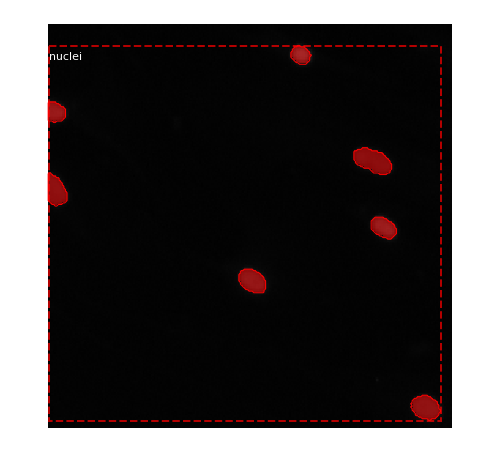

In [294]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [295]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:   77.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  -26.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


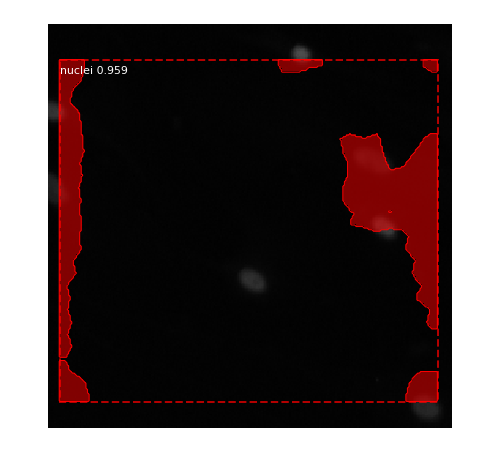

In [296]:
results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())